In [1]:
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
import matplotlib.pyplot as plt


In [568]:
# sample rate
sr = 44100
# seconds
T = 2.0
# time variable
t = np.linspace(0, T, int(T * sr), endpoint=False)
freq = 140.0
# Tone
phase = 2.0 * np.pi * freq * t
x = 1.0 * np.sin(phase + (t * 10.0) * np.sin(phase)) + 0.0 * (2.0 - t) ** 4.0 * np.random.randn(t.shape[0])
Audio(x, rate=sr, autoplay=False) # load a NumPy array

In [571]:
def classic_spec(x, sample_rate=44100, window_time=40e-3, hop_time=20e-3):
    window_length = round(sample_rate * window_time)
    hop_length = round(sample_rate * hop_time)
    fft_length = window_length // 2 + 1
    num_mels = round(fft_length / 4.5)
    melbank = torchaudio.functional.melscale_fbanks(fft_length, 0.0, sample_rate / 2.0, num_mels, sample_rate, None, 'htk').numpy()
    y = torchaudio.transforms.Spectrogram(n_fft=window_length, win_length=window_length, hop_length=hop_length, normalized='window')(torch.tensor(x)).numpy()
    yy = melbank.transpose() @ y
    return yy

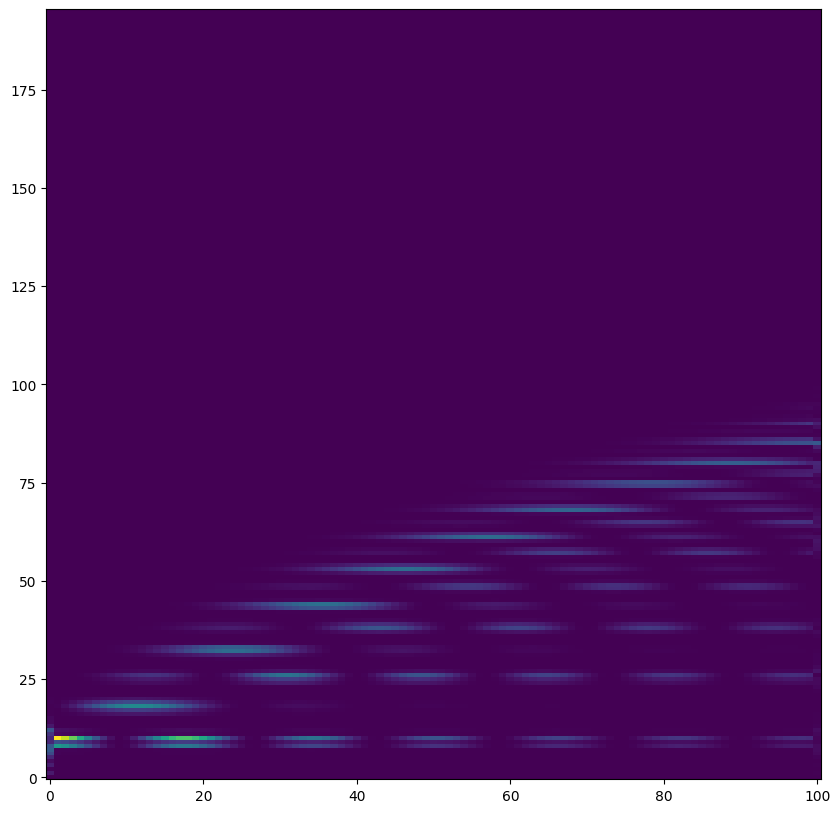

In [572]:
def plot_spectrogram(s):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.imshow(s, origin='lower', aspect='auto')


sx = classic_spec(x)
plot_spectrogram(sx)

In [573]:
sx.shape

(196, 101)

In [574]:
def hz_to_mel(f):
    return 2595.0 * np.log10(1.0 + (f / 700.0))

def mel_to_hz(m):
    return 700.0 * (np.exp(np.log(10.0) / 2595.0 * m) - 1.0)


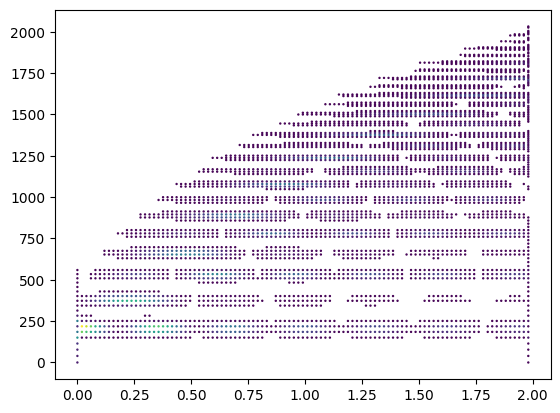

In [575]:

def window(n):
    #return torch.linspace(-1, 1, n) * torch.hann_window(n)
    return torch.hann_window(n)

def classic_spec_pts(x, sample_rate=44100, window_time=40e-3, hop_time=20e-3):
    window_length = round(sample_rate * window_time)
    hop_length = round(sample_rate * hop_time)
    y = torchaudio.transforms.Spectrogram(window_fn=window, n_fft=window_length, win_length=window_length, hop_length=hop_length)(torch.tensor(x)).numpy()
    tmax = y.shape[1]
    wmax = y.shape[0]
    tpos = np.broadcast_to(np.linspace(0, x.shape[0] / sample_rate, tmax, endpoint=False), (wmax, tmax)).reshape(-1)
    wpos = np.broadcast_to(np.linspace(0, sample_rate / 2, wmax, endpoint=False), (tmax, wmax)).transpose().reshape(-1)
    threshold = 1e2
    lvls = y.reshape(-1)
    w = lvls > threshold
    return (tpos[w], hz_to_mel(wpos[w]), lvls[w])

tpos, wpos, lvls = classic_spec_pts(x)

plt.scatter(tpos, wpos, c=lvls, s=0.5)


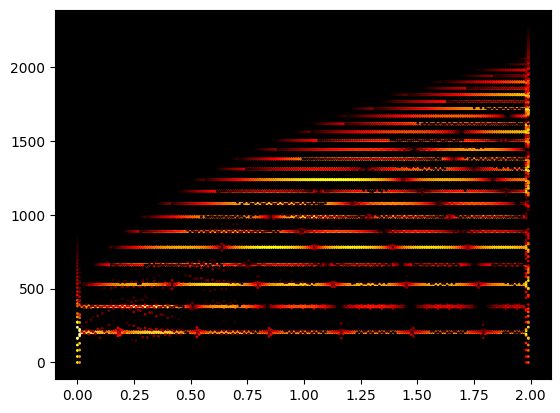

In [577]:
def window(n):
    #return torch.linspace(-1, 1, n) * torch.hann_window(n)
    return torch.hann_window(n)

def classic_spec_pts(x, sample_rate=44100, window_time=40e-3, hop_time=10e-3):
    window_length = round(sample_rate * window_time)
    hop_length = round(sample_rate * hop_time)
    # Normal window for normal FFT
    window = torch.hann_window(window_length)
    # Time-weighted window for time adjustments
    window_tw = torch.linspace(-1, 1, window_length) * window
    # Frequency-weighted window for frequency adjustments
    window_fw = -torch.real(torch.fft.ifft(1j * torch.linspace(0, 2.0 * 2.0 * 3.14159, window_length) * torch.fft.fft(window)))
    # Normal FFT
    y = torch.stft(torch.tensor(x), n_fft=window_length, hop_length=hop_length,
                   win_length=window_length, window=window, return_complex=True).numpy()
    # Frequency-weighted FFT
    yfw = torch.stft(torch.tensor(x), n_fft=window_length, hop_length=hop_length,
                   win_length=window_length, window=window_fw, return_complex=True).numpy()
    # Compute power levels
    ylvl = np.abs(y) ** 2.0
    tmax = y.shape[1]
    wmax = y.shape[0]
    # Reshape tensors to 1D for data shuffling
    y = y.reshape(-1)
    yfw = yfw.reshape(-1)
    tpos = np.broadcast_to(np.linspace(0, x.shape[0] / sample_rate, tmax, endpoint=False), (wmax, tmax)).reshape(-1)
    wpos = np.broadcast_to(np.linspace(0, sample_rate / 2, wmax, endpoint=False), (tmax, wmax)).transpose().reshape(-1)
    threshold = 1e1
    lvls = ylvl.reshape(-1)
    # Find where power exceeds threshold
    w = lvls > threshold
    # Adjust frequencies
    wadj = wpos[w] + np.imag(y[w] * yfw[w].conj() / lvls[w]) / (2.0 * np.pi) * (1 / window_length * sample_rate)
    # Extract data from those positions
    return (tpos[w], wadj, np.log(np.maximum(lvls[w], 1e-8)), y[w], yfw[w])

tpos, wpos, lvls, y, yfw = classic_spec_pts(x)

fig = plt.figure(1)
fig.add_subplot(111, facecolor='black')
plt.scatter(tpos, hz_to_mel(wpos), c=lvls, s=1.0, cmap='hot')

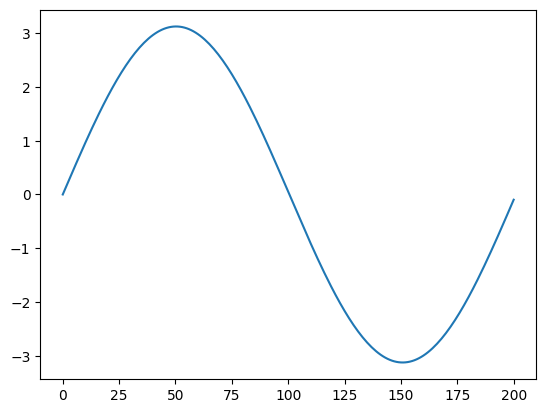

In [517]:
n = 201
# plt.plot(torch.linspace(-1, 1, n) * torch.hann_window(n));
w = torch.hann_window(n)
dw = -torch.real(torch.fft.ifft(1j * torch.linspace(0, 2.0 * 2.0 * 3.14159, n) * torch.fft.fft(w)))
plt.plot(dw);

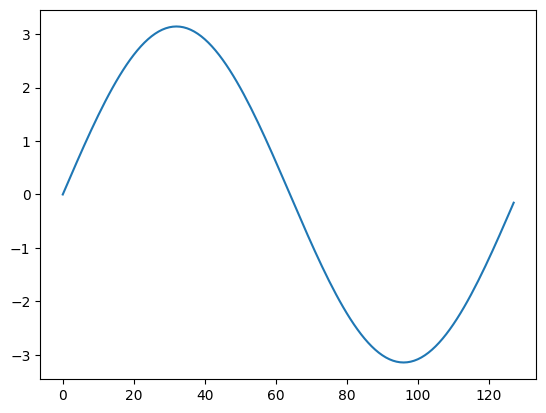

In [484]:
n = 128
w = torch.hann_window(n)
iw = torch.linspace(0, 1, n + 1)[:-1]
mw = torch.sin(iw * 3.14159) ** 2.0
dmw = 2.0 * torch.sin(iw * 3.14159) * 3.14159 * torch.cos(iw * 3.14159)
plt.plot(dmw);


In [485]:
3j

3j

In [487]:
ti = (tpos > 1.0) & (tpos < 1.01)
print(wpos[ti])
print(lvls[ti])
print(y[ti])
print(yfw[ti])

[ 79.89130435 119.83695652 159.7826087  199.72826087]
[ 2193.28522156 54849.72601768 54540.25834267  2170.4312887 ]
[  27.94556365 +37.58098846j -137.40746087-189.65472763j
  137.43340179+188.81821526j  -27.27207758 -37.77122017j]
[ 372.88519671-248.77749732j -581.75362988+438.36668449j
 -587.0048703 +438.20377j     361.18864727-253.33098062j]


In [490]:
y[ti] * yfw[ti].conj() / (np.abs(y[ti]) ** 2.0)

array([ 0.4883919 +9.55900375j, -0.05835991+3.10971798j,
        0.03789453-3.13641798j, -0.1298104 -9.46880843j])

In [495]:
np.imag(y[ti] * yfw[ti].conj() / lvls[ti]) / (2.0 * np.pi)

array([ 1.5213627 ,  0.49492699, -0.49917642, -1.50700767])

In [497]:
n = round(44100*25e-3)
n

1102

In [506]:
wpos[ti] + np.imag(y[ti] * yfw[ti].conj() / lvls[ti]) / (2.0 * np.pi) * (1 / n * 44100)

array([140.77342321, 139.6430184 , 139.80649225, 139.42060381])

<function cycler.cycler(*args, **kwargs)>